In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bayes_implicit_solvent.utils import remove_top_right_spines
%matplotlib inline

result = np.load('../bayes_implicit_solvent/data/elemental_types_mh_freesolv_n_config=25_gaussian_ll.npz')

In [2]:
list(result.keys())

['traj',
 'log_probs',
 'acceptance_fraction',
 'stepsize',
 'n_steps',
 'dim_to_perturb',
 'cids',
 'n_configuration_samples']

In [3]:
traj = result['traj']

In [4]:
log_probs = result['log_probs']

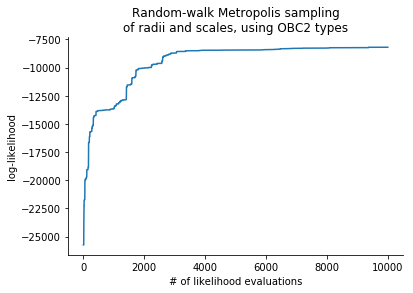

In [5]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

plt.plot(log_probs)
plt.xlabel('# of likelihood evaluations')
plt.ylabel('log-likelihood')

title = 'Random-walk Metropolis sampling\nof radii and scales, using OBC2 types'
plt.title(title)

plt.savefig('rwmh_plots/log-likelihood.png', dpi=300)

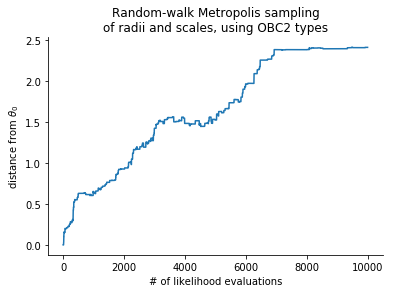

In [6]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

plt.plot(np.linalg.norm(traj - traj[0], axis=1))
plt.xlabel('# of likelihood evaluations')
plt.ylabel(r'distance from $\theta_0$')
plt.title(title)

plt.savefig('rwmh_plots/distance-from-start.png', dpi=300)

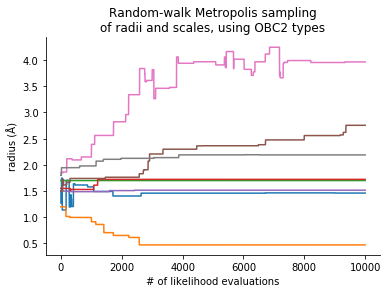

In [7]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

n = int(traj.shape[1] / 2)
plt.plot(traj[:, :n] * 10)

plt.xlabel('# of likelihood evaluations')
plt.ylabel('radius (Å)')

plt.title(title)

plt.savefig('rwmh_plots/radii.png', dpi=300)

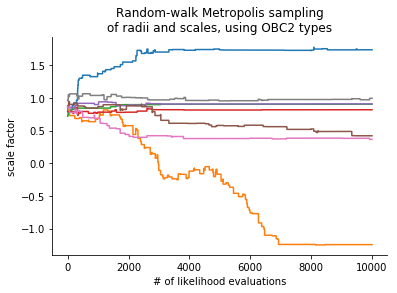

In [8]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

n = int(traj.shape[1] / 2)
plt.plot(traj[:, n:])

plt.xlabel('# of likelihood evaluations')
plt.ylabel('scale factor')

plt.title(title)

plt.savefig('rwmh_plots/scales.png', dpi=300)

In [9]:
min(log_probs)

-25732.497993397083

In [10]:
from bayes_implicit_solvent.continuous_parameter_experiments import gradient_free
from bayes_implicit_solvent.continuous_parameter_experiments.gradient_free import extract_cid_key
from bayes_implicit_solvent.freesolv import cid_to_smiles
from bayes_implicit_solvent.molecule import Molecule

number of molecules being considered: 642


In [11]:
from pkg_resources import resource_filename
from glob import glob
path_to_vacuum_samples = resource_filename('bayes_implicit_solvent',
                                           'vacuum_samples/vacuum_samples_*.npy')
paths_to_samples = glob(path_to_vacuum_samples)
np.random.seed(0)
np.random.shuffle(paths_to_samples)
paths_to_samples = paths_to_samples#
train_paths_to_samples = paths_to_samples[::2]
test_paths_to_samples = paths_to_samples[1::2]

print('number of molecules being considered: {}'.format(len(paths_to_samples)))

cids = list(map(extract_cid_key, paths_to_samples))
train_cids = list(map(extract_cid_key, train_paths_to_samples))
test_cids = list(map(extract_cid_key, test_paths_to_samples))
print('first few CIDs', cids[:5])

mols = []

n_configuration_samples = 50

for path in paths_to_samples:
    cid = extract_cid_key(path)
    smiles = cid_to_smiles[cid]
    vacuum_samples = gradient_free.sample_path_to_unitted_snapshots(path)
    thinning = int(len(vacuum_samples) / n_configuration_samples)
    mol = Molecule(smiles, vacuum_samples=vacuum_samples[::thinning])
    mols.append(mol)
    
from bayes_implicit_solvent.gb_models.obc2_parameters import obc2_model

type_slices = [obc2_model.apply_to_molecule(mol.mol) for mol in mols]

def construct_arrays(theta):
    n = int(len(theta) / 2)
    radii, scales = theta[:n], theta[n:]

    parameterized_list = []
    for i in range(len(mols)):
        parameterized_list.append((radii[type_slices[i]], scales[type_slices[i]]))
    return parameterized_list

number of molecules being considered: 642
first few CIDs ['mobley_3187514', 'mobley_1363784', 'mobley_900088', 'mobley_9913368', 'mobley_766666']


In [12]:
from simtk import unit
from bayes_implicit_solvent.constants import beta
def unreduce(value):
    """Input value is in units of kB T, turn it into units of kilocalorie_per_mole"""
    return value / (beta * unit.kilocalorie_per_mole)

def make_predictions(theta):
    predictions = np.zeros(len(mols))
    parameterized_list = construct_arrays(theta)
    for i, mol in enumerate(mols):
        radii, scale_factors = parameterized_list[i]
        predictions[i] = mol.predict_solvation_free_energy(radii, scale_factors)[0]
    return unreduce(predictions)

In [13]:
%%time
initial_predictions = make_predictions(traj[0])

CPU times: user 3.75 s, sys: 20.4 ms, total: 3.77 s
Wall time: 3.79 s


In [14]:
%%time
optimized_predictions = make_predictions(traj[-1])

CPU times: user 3.65 s, sys: 19.3 ms, total: 3.67 s
Wall time: 3.69 s


In [15]:
mol = mols[0]
mol.experimental_value

-9.333559357658267

In [16]:
experimental_values = np.zeros(len(mols))
for i in range(len(mols)):
    experimental_values[i] = unreduce(mols[i].experimental_value)

In [17]:
sum((experimental_values >= -15) * (experimental_values <= 5))

631

In [18]:
mask = (experimental_values >= -15) * (experimental_values <= 5)
mask[:5]

array([ True,  True,  True,  True,  True])

In [19]:
len(experimental_values)

642

In [27]:
max(experimental_values)

3.4300000000000006

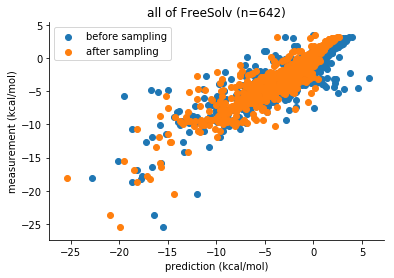

In [21]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

plt.scatter(initial_predictions, experimental_values, label='before sampling')
plt.scatter(optimized_predictions, experimental_values, label='after sampling')
plt.legend()
plt.xlabel('prediction (kcal/mol)')
plt.ylabel('measurement (kcal/mol)')

all_freesolv_descr = 'all of FreeSolv (n={})'.format(len(experimental_values))
plt.title(all_freesolv_descr)


plt.savefig('rwmh_plots/scatter-all-freesolv.png', dpi=300)

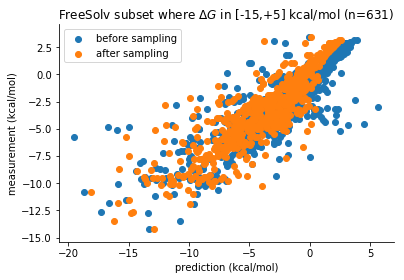

In [22]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

plt.scatter(initial_predictions[mask], experimental_values[mask], label='before sampling')
plt.scatter(optimized_predictions[mask], experimental_values[mask], label='after sampling')

freesolv_subset_descr = 'FreeSolv subset where $\Delta G$ in [-15,+5] kcal/mol (n={})'.format(sum(mask))
plt.title(freesolv_subset_descr)
plt.legend()
plt.xlabel('prediction (kcal/mol)')
plt.ylabel('measurement (kcal/mol)')

plt.savefig('rwmh_plots/scatter-freesolv-subset.png', dpi=300)

In [25]:
np.sqrt(np.mean((initial_predictions - experimental_values)**2)), np.sqrt(np.mean((optimized_predictions - experimental_values)**2))

(2.513530761751582, 2.024685660490917)

In [26]:
np.sqrt(np.mean((initial_predictions[mask] - experimental_values[mask])**2)), np.sqrt(np.mean((optimized_predictions[mask] - experimental_values[mask])**2))

(2.448801645878778, 1.9827511378802947)

In [28]:
from tqdm import tqdm
thinning = 100

prediction_traj = []

for snapshot in tqdm(traj[::thinning]):
    prediction_traj.append(make_predictions(snapshot))

100%|██████████| 101/101 [06:08<00:00,  3.65s/it]


In [29]:
prediction_traj = np.array(prediction_traj)
prediction_traj.shape

(101, 642)

In [30]:
x = np.arange(len(traj))[::thinning]

In [31]:
train_rmses = []
test_rmses = []
for predictions in prediction_traj:
    train_rmses.append(np.sqrt(np.mean((predictions[::2] - experimental_values[::2])**2)))
    test_rmses.append(np.sqrt(np.mean((predictions[1::2] - experimental_values[1::2])**2)))

In [32]:
n_train, n_test = len(predictions[::2]), len(predictions[1::2])

In [33]:
min(train_rmses), min(test_rmses)

(1.937388638810933, 2.000716055955694)

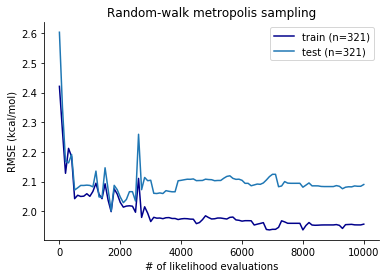

In [34]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

plt.plot(x, train_rmses, color='darkblue', label='train (n={})'.format(n_train))
plt.plot(x, test_rmses, label='test (n={})'.format(n_test))
#plt.ylim(0,)
plt.xlabel('# of likelihood evaluations')
plt.ylabel('RMSE (kcal/mol)')
plt.title('Random-walk metropolis sampling')
plt.legend()

plt.savefig('rwmh_plots/rmse-trace.png', dpi=300)

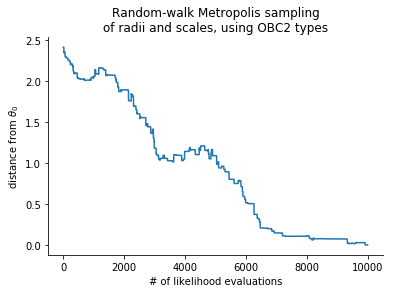

In [35]:
ax = plt.subplot(111)
remove_top_right_spines(ax)

plt.plot(np.linalg.norm(traj - traj[-1], axis=1))
plt.xlabel('# of likelihood evaluations')
plt.ylabel(r'distance from $\theta_0$')
plt.title(title)

plt.savefig('rwmh_plots/distance-from-end.png', dpi=300)

In [36]:
obc2_model.ordered_nodes

['*', '[#1]', '[#6]', '[#7]', '[#8]', '[#9]', '[#15]', '[#16]']

In [37]:
initial_radii = traj[0][:n]
initial_scales = traj[0][n:]

initial_radii

array([0.15 , 0.12 , 0.17 , 0.155, 0.15 , 0.15 , 0.185, 0.18 ])

In [38]:
optimized_radii = traj[-1][:n]
optimized_scales = traj[-1][n:]

In [39]:
list(zip(obc2_model.ordered_nodes, initial_radii))

[('*', 0.15),
 ('[#1]', 0.12),
 ('[#6]', 0.17),
 ('[#7]', 0.155),
 ('[#8]', 0.15),
 ('[#9]', 0.15),
 ('[#15]', 0.185),
 ('[#16]', 0.18)]

In [40]:
list(zip(obc2_model.ordered_nodes, [float('{:.3f}'.format(x)) for x in optimized_radii]))

[('*', 0.146),
 ('[#1]', 0.047),
 ('[#6]', 0.17),
 ('[#7]', 0.172),
 ('[#8]', 0.152),
 ('[#9]', 0.276),
 ('[#15]', 0.397),
 ('[#16]', 0.219)]

In [41]:
list(zip(obc2_model.ordered_nodes, initial_scales))

[('*', 0.8),
 ('[#1]', 0.85),
 ('[#6]', 0.72),
 ('[#7]', 0.79),
 ('[#8]', 0.85),
 ('[#9]', 0.88),
 ('[#15]', 0.86),
 ('[#16]', 0.96)]

In [42]:
list(zip(obc2_model.ordered_nodes, [float('{:.3f}'.format(x)) for x in optimized_scales]))

[('*', 1.736),
 ('[#1]', -1.246),
 ('[#6]', 0.903),
 ('[#7]', 0.818),
 ('[#8]', 0.908),
 ('[#9]', 0.42),
 ('[#15]', 0.365),
 ('[#16]', 0.994)]

(array([ 2.,  5.,  8., 32.,  4.,  1.,  2.,  2.,  1.,  3., 10., 20.,  0.,
         1.,  0.,  0.,  2.,  0.,  0.,  3.,  0.,  1.,  1.,  0.,  0.,  0.,
         0.,  0.,  2.,  1.]),
 array([-3.03695362, -3.02360455, -3.01025548, -2.9969064 , -2.98355733,
        -2.97020826, -2.95685919, -2.94351012, -2.93016104, -2.91681197,
        -2.9034629 , -2.89011383, -2.87676476, -2.86341568, -2.85006661,
        -2.83671754, -2.82336847, -2.8100194 , -2.79667032, -2.78332125,
        -2.76997218, -2.75662311, -2.74327404, -2.72992496, -2.71657589,
        -2.70322682, -2.68987775, -2.67652868, -2.6631796 , -2.64983053,
        -2.63648146]),
 <a list of 30 Patch objects>)

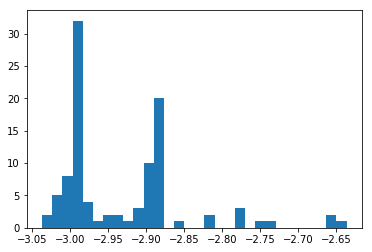

In [43]:
plt.hist(prediction_traj[:,1], bins=30)


In [44]:
predictive_stdevs = np.std(prediction_traj, axis=0)

(array([11., 31., 42., 29., 24., 35., 24., 15., 14., 15., 10.,  9.,  7.,
         9.,  6.,  8.,  5.,  7.,  3.,  0.,  1.,  2.,  2.,  2.,  3.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([0.08176126, 0.11696375, 0.15216624, 0.18736874, 0.22257123,
        0.25777372, 0.29297621, 0.3281787 , 0.36338119, 0.39858369,
        0.43378618, 0.46898867, 0.50419116, 0.53939365, 0.57459614,
        0.60979863, 0.64500113, 0.68020362, 0.71540611, 0.7506086 ,
        0.78581109, 0.82101358, 0.85621607, 0.89141857, 0.92662106,
        0.96182355, 0.99702604, 1.03222853, 1.06743102, 1.10263351,
        1.13783601, 1.1730385 , 1.20824099, 1.24344348, 1.27864597,
        1.31384846, 1.34905095, 1.38425345, 1.41945594, 1.45465843,
        1.48986092, 1.52506341, 1.5602659 , 1.5954684 , 1.63067089,
        1.66587338, 1.70107587, 1.73627836, 1.77148085, 1.80668334,
        1.84188584]),
 <a list of 50

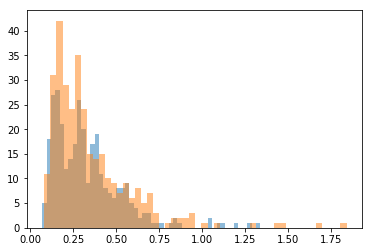

In [45]:
plt.hist(predictive_stdevs[::2], bins=50, alpha=0.5)
plt.hist(predictive_stdevs[1::2], bins=50, alpha=0.5)

In [46]:
prediction_traj

array([[ -5.55082305,  -3.03695362,   1.58471559, ...,   1.91057185,
         -8.32163798, -13.75583827],
       [ -5.56225818,  -2.63648146,   1.24428516, ...,   1.47544728,
         -8.07232152, -11.62565033],
       [ -6.42923824,  -3.02280812,   0.86335619, ...,   1.17427664,
         -9.190115  , -12.50147174],
       ...,
       [ -5.97952784,  -2.99004686,  -0.1517132 , ...,   0.44102099,
         -9.53371504, -11.7500802 ],
       [ -5.97952784,  -2.99004686,  -0.1517132 , ...,   0.44102099,
         -9.53371504, -11.7500802 ],
       [ -5.96315683,  -2.97819339,  -0.15300036, ...,   0.4370658 ,
         -9.52108469, -11.58055366]])

In [48]:
'{:.3f}'.format(max(log_probs))

'-8200.148'

In [49]:
log_probs[0]

-25732.497993397083

In [52]:
log_probs[0] / log_probs[-1]

3.1380529148923584

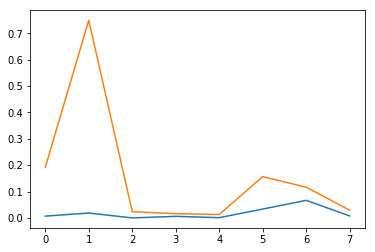

In [57]:
plt.plot(np.std(traj, 0)[:n])
plt.plot(np.std(traj, 0)[n:])